<a href="https://colab.research.google.com/github/brooke57/BrainTumorImageClassification/blob/main/Exploring_the_Black_Box_with_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Black Box with Lime**

In [ ]:
# Getting environment info (output cleared to save space, but saved in a file called "Environment_Requirements")
# ! pip freeze

In [2]:
# Installing Lime
! pip install lime

     |████████████████████████████████| 275 kB 4.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=513f6206e005eae6f84f98147735dc2bf6f20768f3eb28600803c8f001940a4a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
# Set random state for numpy operations
from numpy.random import seed
seed(2)
# Set random state for tensorflow operations
from tensorflow.random import set_seed
set_seed(3)
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import cv2
import PIL
# Importing libraries for model interpretability 
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers import scikit_image
from sklearn.utils import check_random_state
import copy
from functools import partial
import scipy as sp
from sklearn.linear_model import Ridge
from lime.wrappers.scikit_image import SegmentationAlgorithm

## **Functions**

In [4]:
# Defining a function that will freeze all layers in a pretrained and original network
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Freeze_Pretrained_Base(pretrain, model):
    
    '''This function will freeze all layers in a pretrained and original network
      pretrain: refers to any instantiated pretrained network
      model: the name of the model you are adding the pretrained network to
    '''
    pretrain.trainable = False
    for layer in model.layers:
        print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

In [5]:
# Re-freezing everything except for the last layer of the pretrained CNN
# Code structure from https://github.com/learn-co-curriculum/dsc-using-pretrained-networks-codealong
def Unfreeze_Layers(pretrain, layer_list):
    '''This function takes an instantiated pretrained neural network and a list containing layers to be frozen,
    and freezes those layers in the pretrained neural network.
    
    pretrain: refers to the instantiated pretrained neural network
    layer_list: refers to the list of layers to be frozen in the instantiated pretrained neural network.'''

    pretrain.trainable = True
    for layer in  pretrain.layers:
        if layer.name in layer_list:
            layer.trainable = True
        else:
            layer.trainable = False
        
    for layer in pretrain.layers:
        print(layer.name, layer.trainable)
    print(len(pretrain.trainable_weights))

In [6]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [7]:
def print_metrics(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [8]:
# I modified this function slightly from the one found on: 
# https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb

def network_matrix(model_scores):
    """
    Plots a confusion matrix using the scores that come from evaluating a 
    neural network model using either testing or validation data
   
  
    Parameters:
    model_scores = load_model('model_name.h5').evaluate_generator(test/val_generator) 
  
    Returns:
    confusion matrix
    """
    tn = np.round((model_scores[5])/(model_scores[5] + model_scores[6]), 2)
    fn = np.round((model_scores[7])/(model_scores[7] + model_scores[4]), 2)
    fp = np.round((model_scores[6])/(model_scores[6] + model_scores[5]), 2)
    tp = np.round((model_scores[4])/(model_scores[4] + model_scores[7]), 2)
    
    
    conf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots(figsize=(10, 8))
    heat = sns.heatmap(conf, annot=True, fmt='g', ax=ax )
    heat.set_xticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    heat.set_yticklabels(['Brain Tumor', 'Normal'], fontsize=15)
    plt.ylabel('Predicted Label',fontsize=18)
    plt.xlabel('True Label', fontsize=18)

In [9]:
def print_metrics_confusionmatrix(saved_model_name, generator, test_or_val):

  superior_model = load_model(saved_model_name)
  final_scores = superior_model.evaluate_generator(generator)
  network_matrix(final_scores)
  metrics = ['Loss', 'Accuracy', 'Recall', 'Precision', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives' ]
  
  for i, metric in enumerate(metrics):
    print(test_or_val+' '+ metric + ':', final_scores[i])

In [10]:
def ImageLabelsLime(img, img_idx, exp_num, lab_num, true_label, pred_label):
  
  
    image = img

    explanation_num = exp_num.explain_instance(val_img[img_idx].astype('double'),
                                         best_model.predict, 
                                         top_labels=lab_num,
                                         hide_color=0,
                                         num_samples=1000)
    temp_num, mask_num = explanation_num.get_image_and_mask(explanation_num.top_labels[0],
                                                       positive_only=False, num_features=10,
                                                       hide_rest=False)
    lime_graph = mark_boundaries(temp_num / 2 + 0.5, mask_num)
  
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.imshow(lime_graph)

    plt.tight_layout()
    plt.show()

    print(f'Correct Label: {true_label}')
    print(f'Predicted Label: {pred_label}')

## **Data Retrieval and Loading**

First, I loaded data that I downloaded from kaggle onto my google drive account. Then I followed instructions from [this blog](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e) to load the data into this google colab notebook.

In [11]:
# Retrieve the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#Import libraries
import zipfile
import os
# Load the data
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Brain_MRI_Tumor_Images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') # Takes out files and puts them into the /tmp folder
zip_ref.close()

In [13]:
# Specify the train and test file paths
base_direc = '/tmp/Brain_MRI_Tumor_Images'
train_direc = os.path.join(base_direc, 'Training')
test_direc = os.path.join(base_direc, 'Testing')

## **Data Preparation**

In [14]:
# Code structure from https://github.com/austint1121/OES-PneumoniaClassification/blob/main/Final_Notebook.ipynb
# Set up ImageDataGenerator
train_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,                           
                                   brightness_range=([0.6, 1.5]),
                                   horizontal_flip=True,
                                   validation_split=0.06) # this will set aside a part of training set for validation data
test_imagegen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   zoom_range=([0.6,1]),
                                   rotation_range=10,
                                   brightness_range=([0.6,1.5]),
                                   horizontal_flip=True)
# Bring the data in
train_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                    classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=2699, # Number of images in training set
                                    seed=42,
                                    class_mode='binary',
                                    subset='training')

test_generator = test_imagegen.flow_from_directory(
                                    test_direc,
                                     classes={'no_tumor_test':0,
                                            'AllTumorsTest':1},
                                    target_size=(200,200),
                                    batch_size=394, # Number of Images in testing set
                                    seed=42,
                                    class_mode='binary')

val_generator = train_imagegen.flow_from_directory(
                                    train_direc,
                                     classes={'no_tumor_train':0,
                                            'AllTumorsTrain':1},
                                    target_size=(200,200),
                                    batch_size=171, # Number of images in validation set
                                    seed=42,
                                    class_mode='binary',
                                    subset='validation')

Found 2699 images belonging to 2 classes.
Found 394 images belonging to 2 classes.
Found 171 images belonging to 2 classes.


In [15]:
# Creating variables to contain image vectors and labels for training images
train_img, train_lab = next(train_generator)

In [16]:
# Creating variables to contain image vectors and labels for testing images
test_img, test_lab = next(test_generator)

In [17]:
# Creating variables to contain image vectors and labels for validation images
val_img, val_lab = next(val_generator)

## **Final Model (Uses the Pre-Trained VGG-19 Weights)**

In [18]:
# Instantiating the pretrained VGG-19 model
from keras.applications.vgg19 import VGG19
cnn_vgg = VGG19(weights='imagenet',
               include_top=False,
               input_shape=(200,200,3))

80150528/80134624 [==============================] - 3s 0us/step


In [19]:
# Build first model using pretrained VGG 19 as first layer, and then some dense layers on top
pre_drop = keras.Sequential()
pre_drop.add(cnn_vgg)
pre_drop.add(layers.Flatten())
pre_drop.add(layers.Dense(128, activation='relu'))
pre_drop.add(layers.Dropout(0.4))
pre_drop.add(layers.Dense(1, activation='sigmoid'))

In [20]:
# Freezing all layers in pretrained VGG-19 network
Freeze_Pretrained_Base(cnn_vgg, pre_drop)

vgg19 False
flatten True
dense True
dropout True
dense_1 True
4


In [21]:
# Setting up early stopping and model checkpoints so that model stops training after testing loss stops improving and so that
# weights from the epoch with the lowest testing loss are saved
# Information on how to set up early stopping from: 
# https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review/blob/main/Phase4Review-NNs-Text-Images.ipynb
early_stop_pre3 = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
            ModelCheckpoint(filepath='jan_pre3_best_model.h5', monitor='val_loss',
                           save_best_only=True)]

In [22]:
# Compiling and fitting the model
pre_drop.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

pre_drop_results = pre_drop.fit(x=train_img, y=train_lab,
                                steps_per_epoch=2699//32+1,# number of samples / batch size + 1
                                epochs=20,
                                callbacks= early_stop_pre3,
                                validation_data=(test_img, test_lab),
                                validation_steps=394//32+1)

Epoch 1/20
85/85 [==============================] - 26s 156ms/step - loss: 0.4430 - acc: 0.8740 - recall: 0.9549 - precision: 0.9044 - true_positives: 2222.0000 - true_negatives: 137.0000 - false_positives: 235.0000 - false_negatives: 105.0000 - val_loss: 0.4721 - val_acc: 0.7741 - val_recall: 0.8097 - val_precision: 0.8731 - val_true_positives: 234.0000 - val_true_negatives: 71.0000 - val_false_positives: 34.0000 - val_false_negatives: 55.0000
Epoch 2/20
85/85 [==============================] - 7s 84ms/step - loss: 0.1740 - acc: 0.9329 - recall: 0.9862 - precision: 0.9390 - true_positives: 2295.0000 - true_negatives: 223.0000 - false_positives: 149.0000 - false_negatives: 32.0000 - val_loss: 0.4202 - val_acc: 0.8122 - val_recall: 0.8581 - val_precision: 0.8826 - val_true_positives: 248.0000 - val_true_negatives: 72.0000 - val_false_positives: 33.0000 - val_false_negatives: 41.0000
Epoch 3/20
85/85 [==============================] - 7s 80ms/step - loss: 0.1522 - acc: 0.9415 - recall: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Val Loss: 0.07117877900600433
Val Accuracy: 0.9824561476707458
Val Recall: 1.0
Val Precision: 0.9801324605941772
Val True Positives: 148.0
Val True Negatives: 20.0
Val False Positives: 3.0
Val False Negatives: 0.0


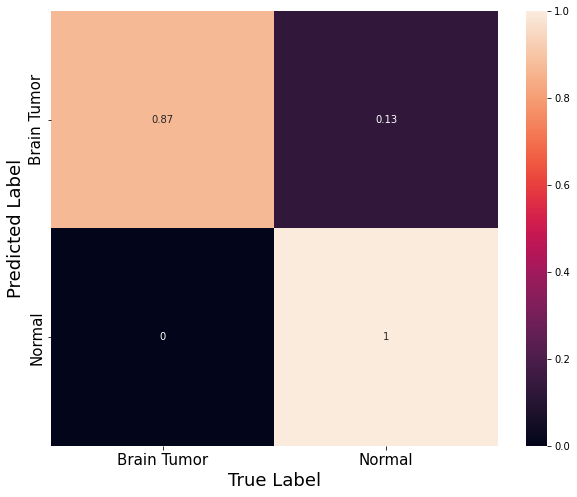

In [ ]:
print_metrics_confusionmatrix('jan_pre3_best_model.h5', val_generator, 'Val')

**Analysis of using final model on Validation data**

When the final model was used to evaluate the validation data, it had excellent performance. Validation accuracy is 98%, with a loss of only 7%. The model has 100% recall, which means that it isn't failing to diagnose tumors when they appear in a MRI scan. This was our goal, so it is excellent that recall has been maximized!

## **Digging in to Model Interpretability**

In [23]:
best_model = load_model('/content/jan_pre3_best_model.h5')

In [24]:
# Predictions for Validation data
val_preds_raw = best_model.predict(val_img)
val_preds = (val_preds_raw > 0.5).astype('int32')


In [25]:
val_lab = val_lab.astype('int32')


In [26]:
# getting the indices of the correctly and incorrectly labelled validation images

right = [i for i in range(len(val_img)) if val_preds[i] == val_lab[i]]
wrong = [i for i in range(len(val_img)) if val_preds[i] != val_lab[i]]
wrong

[64, 68, 69, 72, 128, 153, 165]

In [ ]:
tumor_idxs = [i for i in range(len(val_img)) if val_lab[i] == 1]
normal_idxs = [i for i in range(len(val_img)) if val_lab[i] == 0]
tumor_idxs

In [ ]:
images = [val_img[0], val_img[30], val_img[1], val_img[167], train_img[2], train_img[4]]
titles = ['glioma', 'glioma', 'glioma', 'glioma','meningioma', 'meningioma']

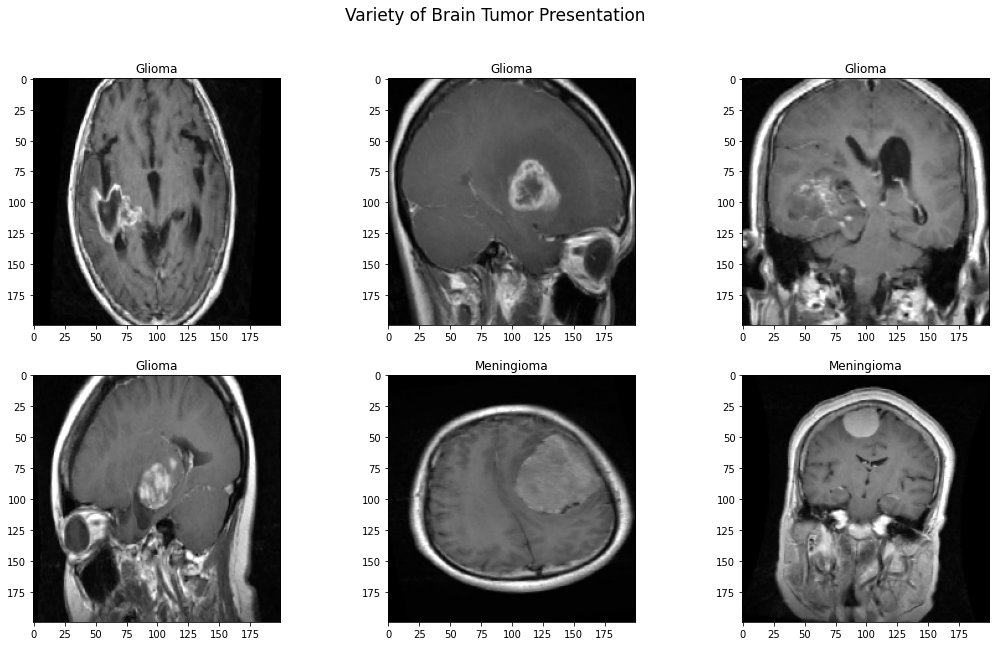

In [ ]:
# Some of code structure from https://stackoverflow.com/questions/48435229/how-to-plot-a-list-of-image-in-loop-using-matplotlib/48435411
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
rows = 2

for num, x in enumerate(images):
    
    ax = axes[num // 3, num % 3]
    ax.imshow(x)
    axes[num//3, num%3].set_title('Glioma')
axes[1,1].set_title('Meningioma')
axes[1,2].set_title('Meningioma');
    
    

fig.suptitle('Variety of Brain Tumor Presentation',fontsize = 17)
plt.show()

One of the aspects that makes brain tumor classification difficult is the variety in appearance that exists within and between different tumor types. Above are shown six different T1 or FLAIR MRIs of four different appearances of gliomas, and two different appearances of meningiomas. Sometimes the tumor appears black (fluid filled) with a white ring, other times the tumor is a lacy, garbled white, sometimes a bright mass with smaller bright patches within, and other times the tumor appears large and white. This variety can be one of the factors which causes the model to make mistakes, which will be explored below.

## **Lime: Normal MRIs labelled as Tumorous**

In [ ]:
exp1 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

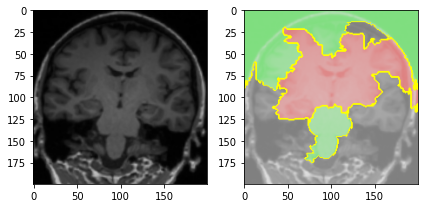

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[64], 64, exp1, 3, val_lab[64], val_preds[64])

In this image, LIME has identified the large, round region of the base of the pons as a region with a high probability of causing the image to be misclassified as containing a tumor. Oftentimes tumors appear in MRIs as large white masses, so perhaps this is what the model is picking up on, and why it incorrectly labels this image.

In [ ]:
exp2 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

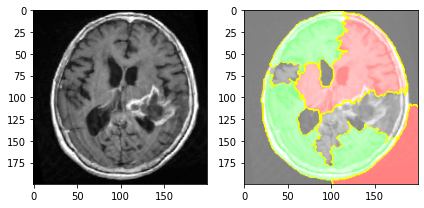

Correct Label: 1
Predicted Label: [0]


In [ ]:
ImageLabelsLime(val_img[68], 68, exp2, 3, val_lab[68], val_preds[68])

The parts of the image that LIME labels as contributing to high and low probabilities of being labelled as the predicted class appear to be fairly random in this MRI. From what LIME shows us, the model was not able to locate the actual tumor in a region contributing to a high probability that this image will be classified as having a tumor, so that is why the image was misclassified.

In [ ]:
exp3 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

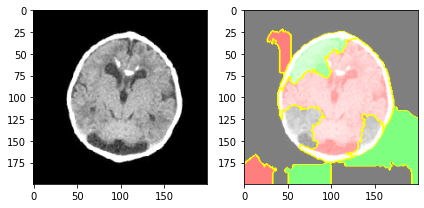

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[69], 69, exp3, 3, val_lab[69], val_preds[69])

The parts of the image that LIME labels as contributing to high and low probabilities of being labelled as the predicted class appear to be fairly random in this MRI.

In [ ]:
exp4 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

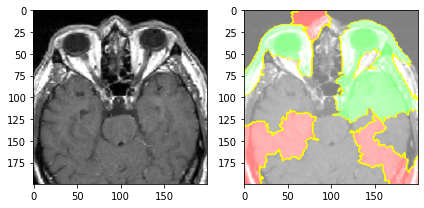

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[72], 72, exp4, 3, val_lab[72], val_preds[72])

In this image, the LIME identifies the eye region as contributing to a high probability that the MRI is misclassified as containing a tumor. This is probably because tumors can also appear in MRIs as a large mass with a white ring and dark center, which is exactly what the eyes look like.

In [ ]:
exp6 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

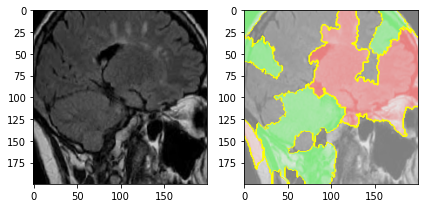

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[128], 128, exp6, 3, val_lab[128], val_preds[128])

In this image, LIME identifies the cerebellum and a large region at the bottom of the brain as contributing to a high probability that the image is misclassified as containing a tumor. Because tumors can contain regions with high black/white contrast in an MRI with lots of edges to detect, perhaps this is what the model is picking up on and what causes it to misclassify this image.

In [ ]:
exp7 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

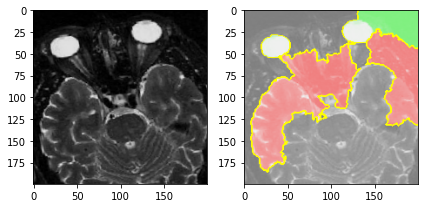

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[153], 153, exp7, 3, val_lab[153], val_preds[153])

In this image, LIME predicted the eyes as having a high probabilty of contributing to the image being misclassified as containing a tumor. Oftentimes tumors appear in MRIs as large white masses, so perhaps this is what the model is picking up on, and why it incorrectly labels this image.

In [ ]:
exp8 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

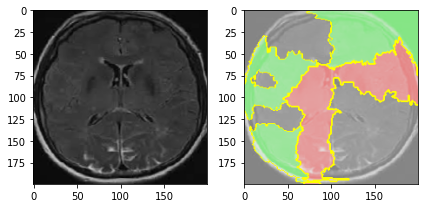

Correct Label: 0
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[165], 165, exp8, 3, val_lab[165], val_preds[165])

The parts of the image that LIME labels as contributing to high and low probabilities of being labelled as the predicted class appear to be fairly random in this MRI.

## **Lime: Images with Tumors**

In [ ]:
exp9 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

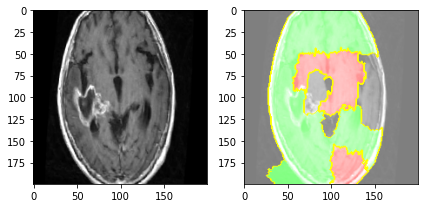

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[0], 0, exp9, 3, val_lab[0], val_preds[0])

In this image, LIME correctly identifies the tumor as contributing to a high probability that the image will be classified as containing a tumor. The tumor is an area of high black and white contrast with lots of edges to detect, so it makes sense that the model is picking up on this.

In [ ]:
exp10 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

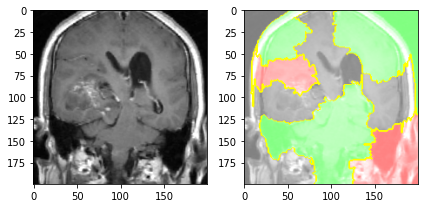

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[1], 1, exp10, 3, val_lab[1], val_preds[1])

In this image, LIME identifies part of the tumorous region as contributing to the lowest probability of the image being classified as containing a tumor. It looks as though a small sliver of the tumorous region may be in on of the regions of highest proobability of MRI being classified as having a tumor, but it is hard to tell. However, it still predicted the correct class, but it may have gotten the correct prediction for the wrong reasons.

In [ ]:
exp11 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

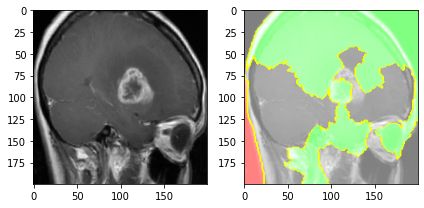

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[30], 30, exp11, 3, val_lab[30], val_preds[30])

In this image, LIME correctly identifies the tumor as contributing to a high probability that the image will be classified as containing a tumor. The tumor is an area of high black and white contrast with lots of edges to detect, so it makes sense that the model is picking up on this.

In [ ]:
exp12 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

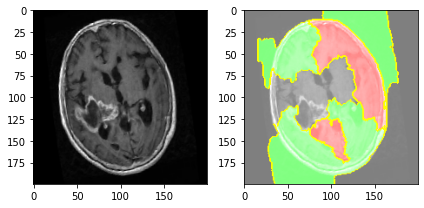

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[40], 40, exp12, 3, val_lab[40], val_preds[40])

In [ ]:
exp13 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

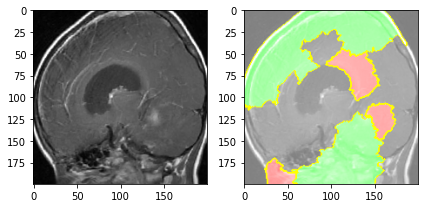

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[50], 50, exp13, 3, val_lab[50], val_preds[50])

In [ ]:
exp14 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

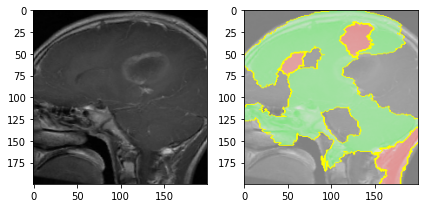

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[62], 62, exp14, 3, val_lab[62], val_preds[62])

In [ ]:
exp15 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

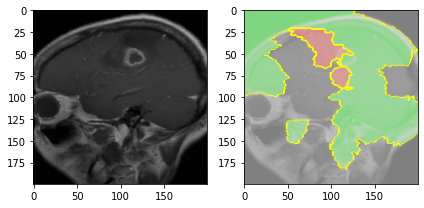

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[160], 160, exp15, 3, val_lab[160], val_preds[160])

In [ ]:
exp16 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

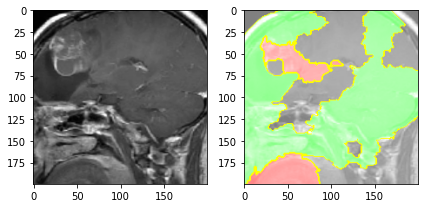

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[12], 12, exp16, 3, val_lab[12], val_preds[12])

In [ ]:
exp17 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

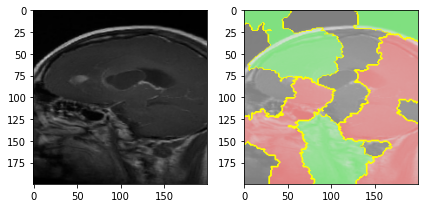

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[100], 100, exp17, 3, val_lab[100], val_preds[100])

In [ ]:
exp18 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

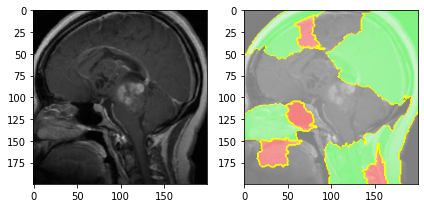

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[170], 170, exp18, 3, val_lab[170], val_preds[170])

In [ ]:
exp19 = lime_image.LimeImageExplainer()

  0%|          | 0/1000 [00:00<?, ?it/s]

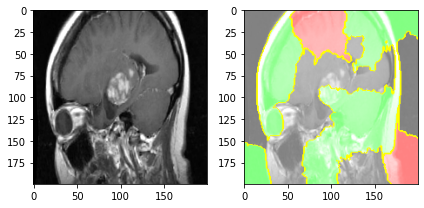

Correct Label: 1
Predicted Label: [1]


In [ ]:
ImageLabelsLime(val_img[167], 167, exp19, 3, val_lab[167], val_preds[167])

## **Explaining How LIME Works**

code comes from a tutorial done in a [medium blog](https://https://towardsdatascience.com/explaining-face-mask-image-classification-model-using-lime-8f423c601ff9) by Ayan Kundu

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


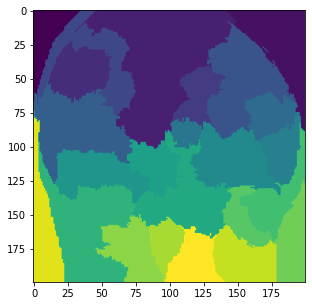

In [27]:
segmentation = scikit_image.SegmentationAlgorithm('quickshift', kernel_size=4,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=42)
val_30 = val_img[30].astype('double')
segments = segmentation(val_30)
# Numbers of superpixels or features of the image
print(np.unique(segments))

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(segments);

In [28]:
segments

array([[ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  1,  1,  1],
       ...,
       [22, 22, 22, ..., 18, 18, 18],
       [22, 22, 22, ..., 18, 18, 18],
       [22, 22, 22, ..., 18, 18, 18]])

In [29]:
exp = lime_image.LimeImageExplainer()

In [32]:
hide = 0

In [33]:
fudge_image = val_30.copy()
 

if hide is None:
    for x in np.unique(segments):
        fudge_image[segments == x] = (
            np.mean(images[0][segments == x][:, 0]),
            np.mean(images[0][segments == x][:, 1]),
            np.mean(images[0][segments == x][:, 2]))
else:
    fudge_image[:] = hide
    
# Creating the perturbed samples and predicting their class y using the CNN model
# btach_size=10 means classifier function will be called in a batch size of 10 to predict the labels for the perturbed samples
data,labels=exp.data_labels(val_30, fudge_image, segments,
                                        classifier_fn= best_model.predict, num_samples=1000,
                                        batch_size=50
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
len(labels)

1000

In [46]:
def perturbed_images_generation(image,fudge_image,segments,data):
    rows = data
    imgs = []
    req_images=[]
    # Iterate through each of the row of the array called data
    for row in rows:
        # temp a copy of the original image
        temp = copy.deepcopy(image)
        # Finding the indexes of the zeros in each row
        zeros = np.where(row == 0)[0]
        # create an temporary array called mask same shape as of segments(here (256,256)) which contains all the values as False
        mask = np.zeros(segments.shape).astype(bool)
        # For each zero(off superpixel) in each row of data replace the image by the fudged_image 
        for z in zeros:
            mask[segments == z] = True
        temp[mask] = fudge_image[mask]
        imgs.append(temp)
        req_images.extend(imgs)
        imgs = []
            
    return req_images

In [47]:
perturbed_images=perturbed_images_generation(val_30,fudge_image,segments,data)

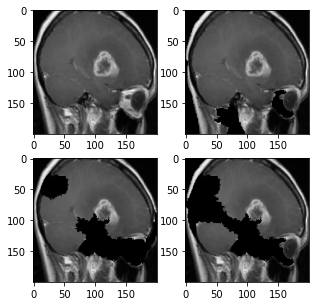

In [49]:
# Calculate the distances between perturbed images and original image
import sklearn
distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric='cosine'
        ).ravel()

# Find the top 3 closest perturbed images
df=pd.DataFrame(distances,columns=['distance'])
df1=df.sort_values(by='distance')
df1=df1.drop_duplicates(keep='first')
req_index=df1.index[1:4]

# Plotting the original and top 3 closest perturbed images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(5,5))
ax1.imshow(perturbed_images[0])
ax2.imshow(perturbed_images[req_index[0]])
ax3.imshow(perturbed_images[req_index[1]])
ax4.imshow(perturbed_images[req_index[2]])

In [1]:
df

NameError: ignored